In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM for Trajectory Prediction

The model architecture for trajectory prediction consists of the following components:
- A CNN for processing the heightmap
- A dense layer for processing the robot state and control inputs
- An LSTM for sequential processing
- An output layer for predicting the next state

The heightmap is processed by a CNN to extract features.
The robot state and control inputs are concatenated and processed by a dense layer.
The heightmap features and processed robot state/control features are concatenated and passed through an LSTM.
The LSTM output is passed through an output layer to predict the next state.

In [2]:
class TrajectoryModel(nn.Module):
    def __init__(self, state_features, control_features, heightmap_shape, lstm_hidden_size):
        super(TrajectoryModel, self).__init__()

        # CNN for processing the entire heightmap
        self.heightmap_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        # Compute CNN output size
        heightmap_height, heightmap_width = heightmap_shape
        pooled_height = heightmap_height // (2 * 2)  # Two pooling layers
        pooled_width = heightmap_width // (2 * 2)
        cnn_output_size = pooled_height * pooled_width * 128

        # Dense layer for robot state + control input processing
        self.robot_state_fc = nn.Linear(state_features + control_features, 64)

        # LSTM for sequential processing
        self.lstm_input_size = 64 + cnn_output_size
        self.lstm = nn.LSTM(self.lstm_input_size, lstm_hidden_size, batch_first=True)

        # Output layer to predict the next state in the sequence
        self.output_fc = nn.Linear(lstm_hidden_size, state_features)

    def forward(self, initial_state, control_inputs, heightmap):
        # Process heightmap through CNN (global terrain context)
        batch_size, _, heightmap_h, heightmap_w = heightmap.size()
        heightmap_features = self.heightmap_cnn(heightmap)  # Shape: (batch_size, cnn_output_size)

        # Repeat heightmap features for each time step in the sequence
        seq_len = control_inputs.size(1)  # Length of the control input sequence
        heightmap_features = heightmap_features.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate initial robot state and control inputs for each time step
        # Initial state is repeated across the sequence
        initial_state_repeated = initial_state.unsqueeze(1).repeat(1, seq_len, 1)
        combined_inputs = torch.cat((initial_state_repeated, control_inputs), dim=-1)  # Shape: (batch_size, seq_len, state_features + control_features)

        # Process combined inputs through a dense layer
        robot_state_features = F.relu(self.robot_state_fc(combined_inputs))

        # Concatenate robot state/control features with heightmap features
        combined_features = torch.cat((robot_state_features, heightmap_features), dim=-1)

        # Pass through LSTM to capture temporal dependencies
        lstm_out, _ = self.lstm(combined_features)

        # Predict next states in the sequence
        output = self.output_fc(lstm_out)

        return output


# Model Instantiation and Forward Pass

Let's instantiate the model and perform a forward pass to predict the next state.

In [3]:
# Model Parameters
state_features = 6  # Example: (x, y, z, roll, pitch, yaw)
control_features = 2  # Example: (v_cmd, w_cmd)
heightmap_shape = (128, 128)  # Example: Heightmap of size 64x64
lstm_hidden_size = 256  # LSTM hidden layer size

# Instantiate the model
model = TrajectoryModel(state_features, control_features, heightmap_shape, lstm_hidden_size)

# Print model summary
print(model)

TrajectoryModel(
  (heightmap_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (robot_state_fc): Linear(in_features=8, out_features=64, bias=True)
  (lstm): LSTM(131136, 256, batch_first=True)
  (output_fc): Linear(in_features=256, out_features=6, bias=True)
)


# Example inputs

Let's create some example inputs for the model and perform a forward pass.

The model expects the following inputs:
- Robot state: A tensor of shape (batch_size, seq_len, state_features)
- Control inputs: A tensor of shape (batch_size, seq_len, control_features)
- Heightmap: A tensor of shape (batch_size, 1, heightmap_height, heightmap_width)

The model predicts the next states as a tensor of shape (batch_size, seq_len, output_size).

In [4]:
# Example inputs
batch_size = 1
T, dt = 5.0, 0.01
seq_len = int(T / dt)

robot_state = torch.randn(batch_size, state_features)  # Robot state at the initial time step
print("Robot state shape:", robot_state.shape)
control_inputs = torch.randn(batch_size, seq_len, control_features)  # Control commands
print("Control inputs shape:", control_inputs.shape)
heightmap = torch.randn(batch_size, 1, *heightmap_shape)  # Single heightmap per batch
print("Heightmap shape:", heightmap.shape)

# Forward pass
output = model(robot_state, control_inputs, heightmap)

# Output shape
print("Output shape:", output.shape)  # Should be (batch_size, seq_len, state_features)

Robot state shape: torch.Size([1, 6])
Control inputs shape: torch.Size([1, 500, 2])
Heightmap shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 500, 6])


# Model Inference

We will use the ROUGH dataset to perform inference using the model.

In [5]:
from monoforce.datasets import ROUGH, rough_seq_paths
from scipy.spatial.transform import Rotation

class Data(ROUGH):
    def __init__(self, path, is_train=False):
        super(Data, self).__init__(path, is_train=is_train)

    def get_sample(self, i):
        control_ts, controls = self.get_controls(i)
        
        traj = self.get_traj(i)
        traj_ts = traj['stamps']
        traj_ts  = torch.as_tensor(traj_ts - traj_ts[0], dtype=torch.float32)
        
        poses = traj['poses']
        xyz = torch.as_tensor(poses[:, :3, 3], dtype=torch.float32)
        Rs = poses[:, :3, :3]
        rpy = torch.as_tensor(Rotation.from_matrix(Rs).as_euler('xyz'), dtype=torch.float32)
        states = torch.cat((xyz, rpy), dim=-1)
        
        hm = self.get_geom_height_map(i)[0:1]
        return (hm,
                control_ts, controls,
                traj_ts, states)

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
ds = Data(rough_seq_paths[0])
print(len(ds))

1016


/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loaded pretrained weights for efficientnet-b0


  0%|          | 0/1 [00:00<?, ?it/s]

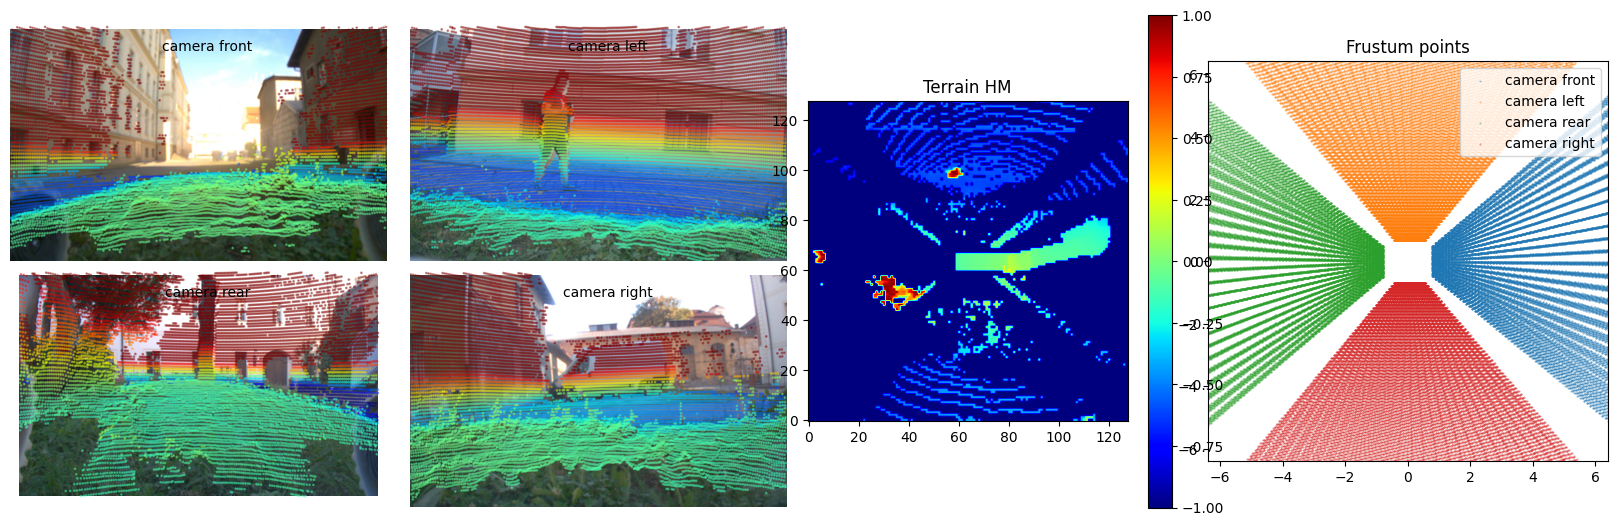

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [7]:
%matplotlib inline
from monoforce.utils import explore_data

sample_i = 120
explore_data(ds, [sample_i])

In [8]:
# Inference
sample = ds[sample_i]
batch = [s[None] for s in sample]
hm, control_ts, controls, traj_ts, xyz_rpy = batch
print("Heightmap shape:", hm.shape)
print("Controls shape:", controls.shape)
print("Robot states shape:", xyz_rpy.shape)

xyz_rpy0 = xyz_rpy[:, 0]
output = model(xyz_rpy0, controls, hm)
print("Output trajectory shape:", output.shape)  # Should be (batch_size, seq_len, output_size)

Heightmap shape: torch.Size([1, 1, 128, 128])
Controls shape: torch.Size([1, 500, 2])
Robot states shape: torch.Size([1, 50, 6])
Output trajectory shape: torch.Size([1, 500, 6])


# Model Training

Iter 1/1000, Loss: 0.7580


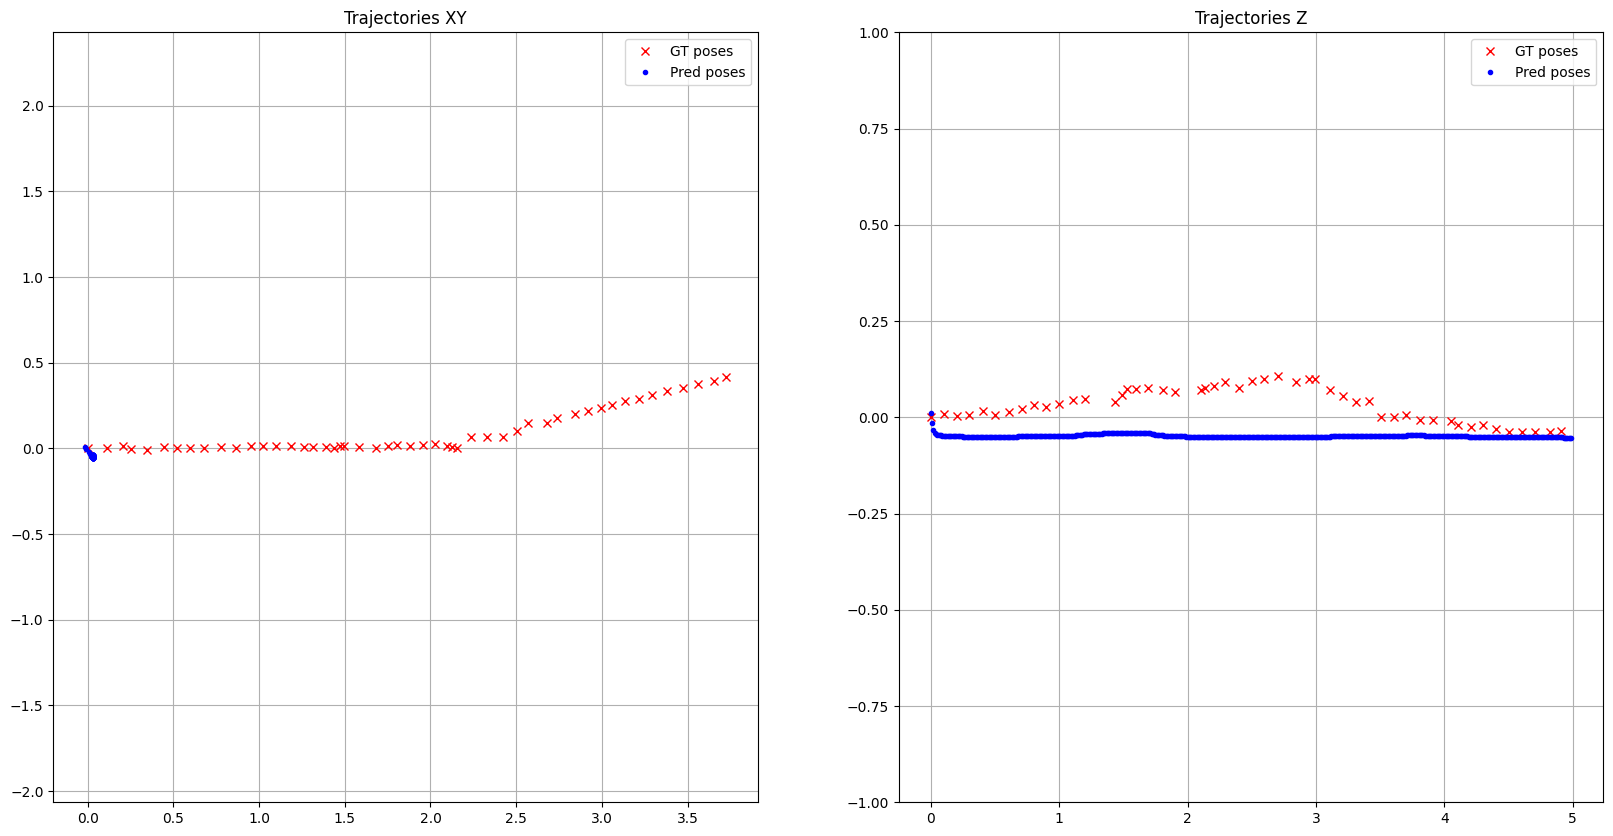

Iter 2/1000, Loss: 0.1985
Iter 3/1000, Loss: 0.2465
Iter 4/1000, Loss: 0.2325
Iter 5/1000, Loss: 0.1973
Iter 6/1000, Loss: 0.1886
Iter 7/1000, Loss: 0.1844
Iter 8/1000, Loss: 0.1855
Iter 9/1000, Loss: 0.1879
Iter 10/1000, Loss: 0.1866
Iter 11/1000, Loss: 0.1941
Iter 12/1000, Loss: 0.1895
Iter 13/1000, Loss: 0.1847
Iter 14/1000, Loss: 0.1811
Iter 15/1000, Loss: 0.1783
Iter 16/1000, Loss: 0.1767
Iter 17/1000, Loss: 0.1762
Iter 18/1000, Loss: 0.1756
Iter 19/1000, Loss: 0.1741
Iter 20/1000, Loss: 0.1720
Iter 21/1000, Loss: 0.1717
Iter 22/1000, Loss: 0.1717
Iter 23/1000, Loss: 0.1706
Iter 24/1000, Loss: 0.1687
Iter 25/1000, Loss: 0.1668
Iter 26/1000, Loss: 0.1654
Iter 27/1000, Loss: 0.1650
Iter 28/1000, Loss: 0.1653
Iter 29/1000, Loss: 0.1654
Iter 30/1000, Loss: 0.1649
Iter 31/1000, Loss: 0.1640
Iter 32/1000, Loss: 0.1633
Iter 33/1000, Loss: 0.1628
Iter 34/1000, Loss: 0.1622
Iter 35/1000, Loss: 0.1612
Iter 36/1000, Loss: 0.1596
Iter 37/1000, Loss: 0.1586
Iter 38/1000, Loss: 0.1583
Iter 39/1

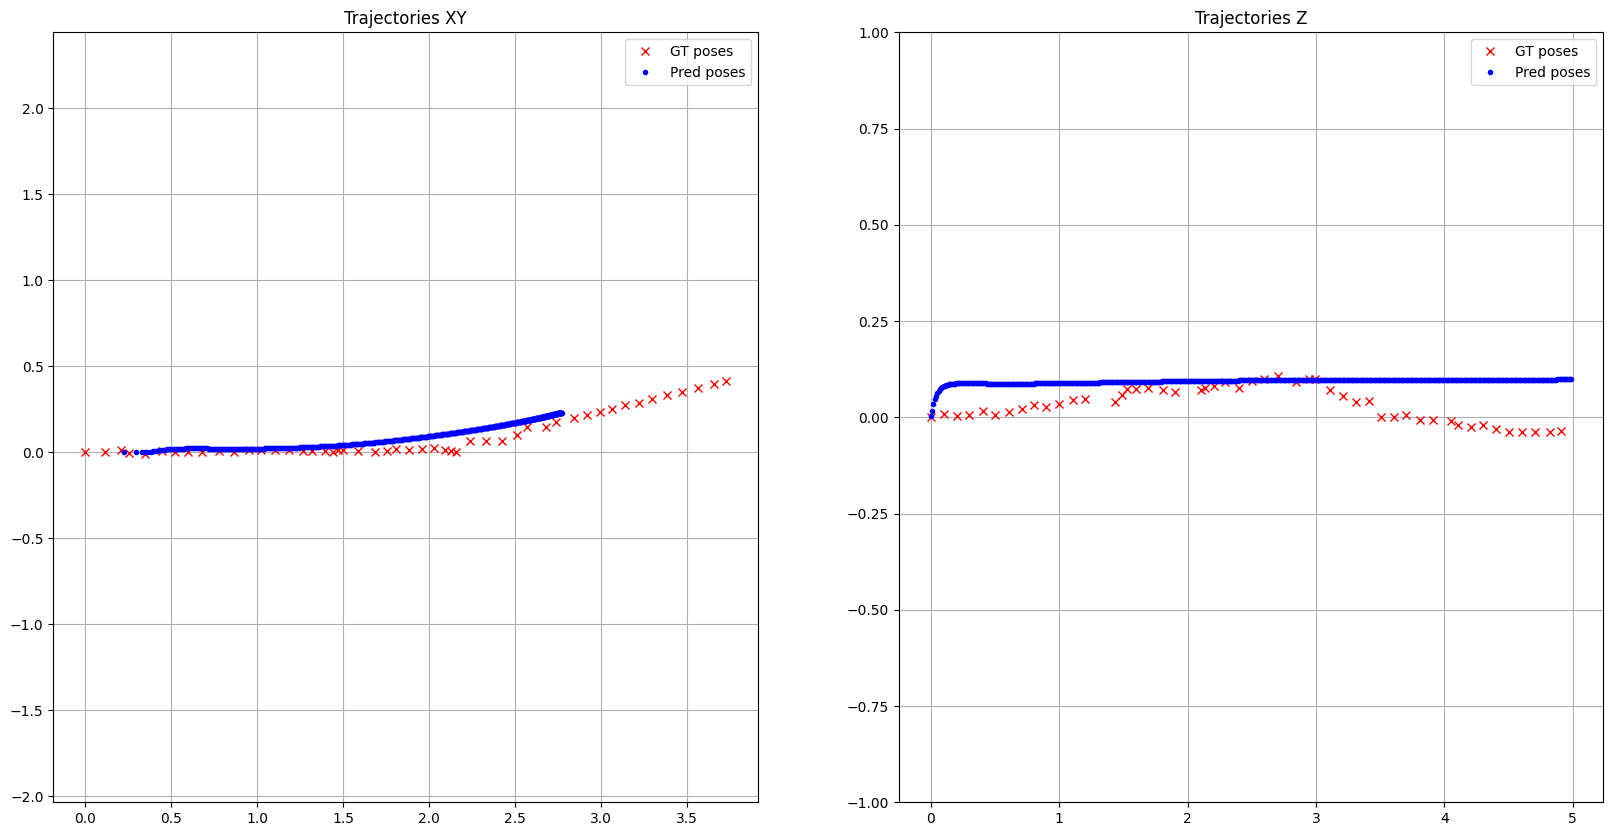

Iter 102/1000, Loss: 0.0320
Iter 103/1000, Loss: 0.0307
Iter 104/1000, Loss: 0.0302
Iter 105/1000, Loss: 0.0298
Iter 106/1000, Loss: 0.0297
Iter 107/1000, Loss: 0.0290
Iter 108/1000, Loss: 0.0278
Iter 109/1000, Loss: 0.0266
Iter 110/1000, Loss: 0.0267
Iter 111/1000, Loss: 0.0267
Iter 112/1000, Loss: 0.0268
Iter 113/1000, Loss: 0.0262
Iter 114/1000, Loss: 0.0243
Iter 115/1000, Loss: 0.0253
Iter 116/1000, Loss: 0.0230
Iter 117/1000, Loss: 0.0276
Iter 118/1000, Loss: 0.0307
Iter 119/1000, Loss: 0.0337
Iter 120/1000, Loss: 0.0355
Iter 121/1000, Loss: 0.0301
Iter 122/1000, Loss: 0.0268
Iter 123/1000, Loss: 0.0327
Iter 124/1000, Loss: 0.0254
Iter 125/1000, Loss: 0.0280
Iter 126/1000, Loss: 0.0290
Iter 127/1000, Loss: 0.0240
Iter 128/1000, Loss: 0.0278
Iter 129/1000, Loss: 0.0250
Iter 130/1000, Loss: 0.0243
Iter 131/1000, Loss: 0.0254
Iter 132/1000, Loss: 0.0217
Iter 133/1000, Loss: 0.0237
Iter 134/1000, Loss: 0.0219
Iter 135/1000, Loss: 0.0206
Iter 136/1000, Loss: 0.0222
Iter 137/1000, Loss:

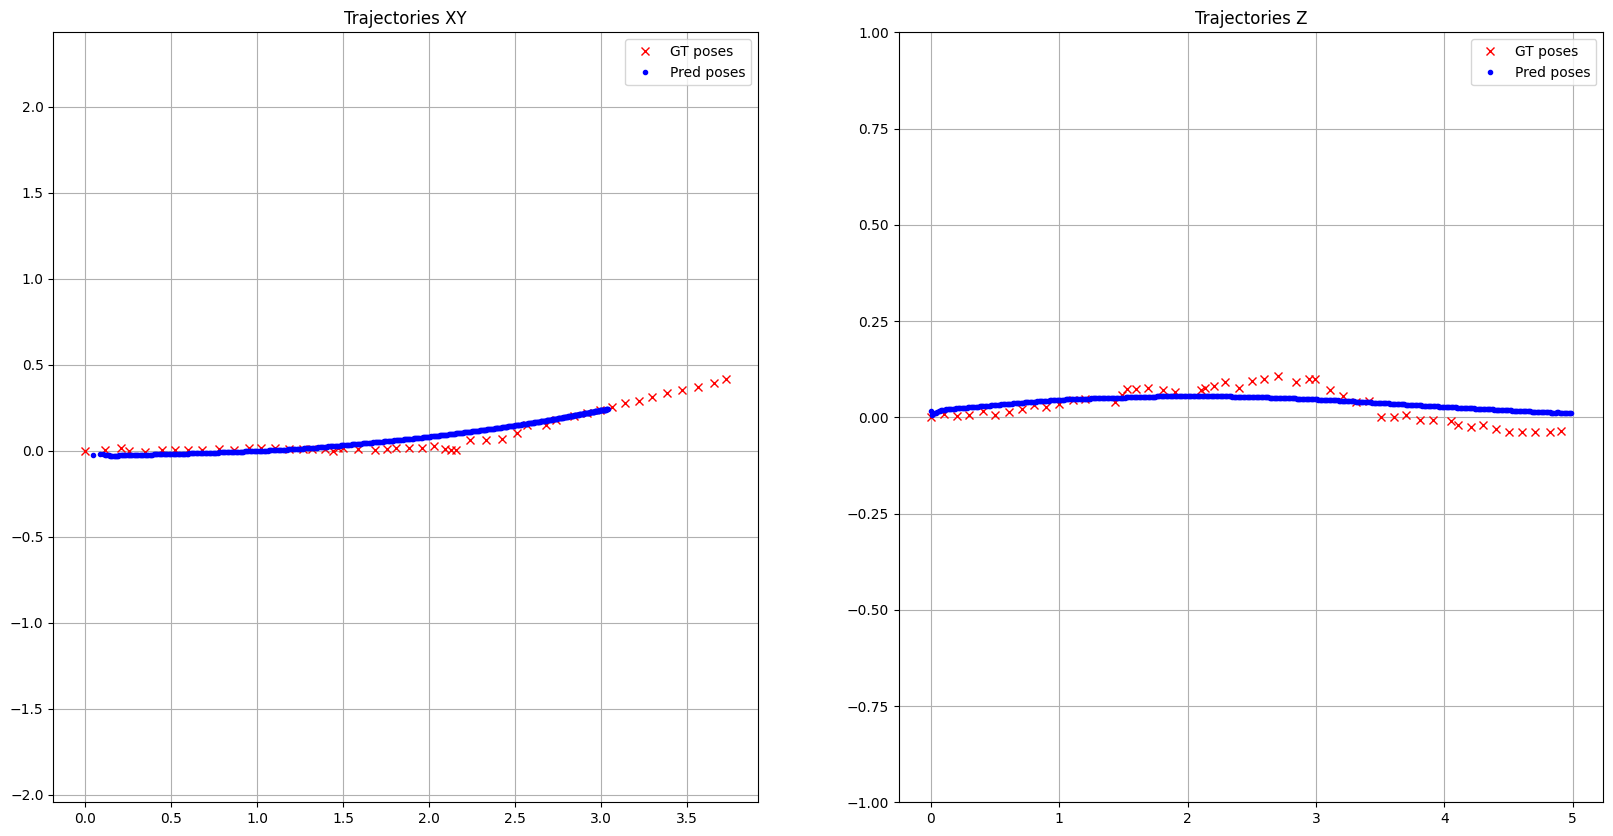

Iter 202/1000, Loss: 0.0092
Iter 203/1000, Loss: 0.0087
Iter 204/1000, Loss: 0.0096
Iter 205/1000, Loss: 0.0108
Iter 206/1000, Loss: 0.0109
Iter 207/1000, Loss: 0.0102
Iter 208/1000, Loss: 0.0088
Iter 209/1000, Loss: 0.0081
Iter 210/1000, Loss: 0.0082
Iter 211/1000, Loss: 0.0088
Iter 212/1000, Loss: 0.0094
Iter 213/1000, Loss: 0.0094
Iter 214/1000, Loss: 0.0091
Iter 215/1000, Loss: 0.0085
Iter 216/1000, Loss: 0.0079
Iter 217/1000, Loss: 0.0075
Iter 218/1000, Loss: 0.0074
Iter 219/1000, Loss: 0.0074
Iter 220/1000, Loss: 0.0076
Iter 221/1000, Loss: 0.0084
Iter 222/1000, Loss: 0.0104
Iter 223/1000, Loss: 0.0170
Iter 224/1000, Loss: 0.0210
Iter 225/1000, Loss: 0.0177
Iter 226/1000, Loss: 0.0085
Iter 227/1000, Loss: 0.0099
Iter 228/1000, Loss: 0.0163
Iter 229/1000, Loss: 0.0117
Iter 230/1000, Loss: 0.0072
Iter 231/1000, Loss: 0.0104
Iter 232/1000, Loss: 0.0117
Iter 233/1000, Loss: 0.0080
Iter 234/1000, Loss: 0.0075
Iter 235/1000, Loss: 0.0102
Iter 236/1000, Loss: 0.0091
Iter 237/1000, Loss:

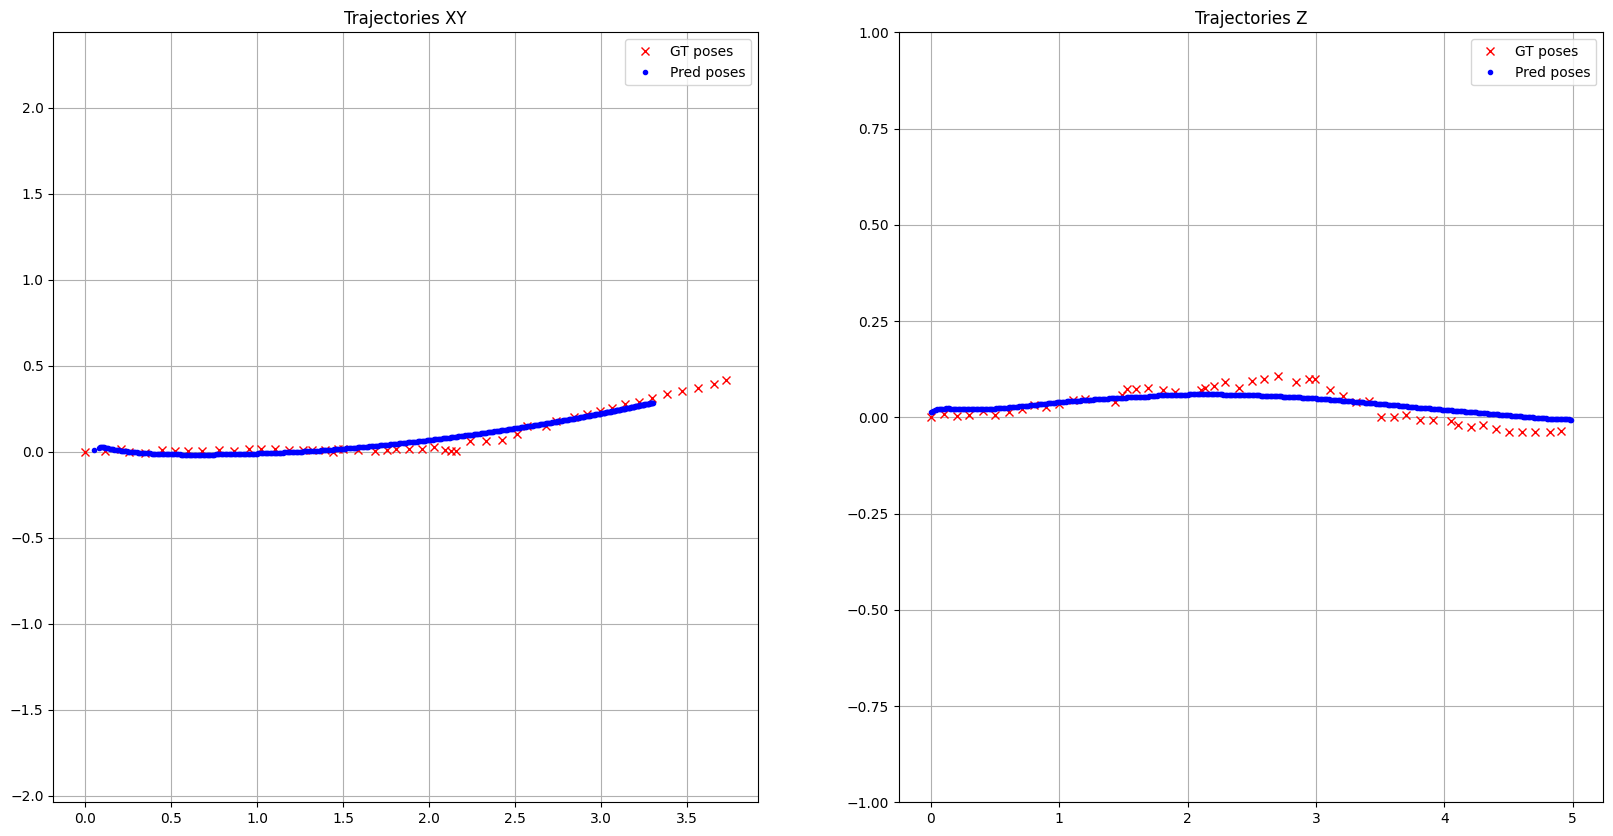

Iter 302/1000, Loss: 0.0051
Iter 303/1000, Loss: 0.0049
Iter 304/1000, Loss: 0.0045
Iter 305/1000, Loss: 0.0044
Iter 306/1000, Loss: 0.0047
Iter 307/1000, Loss: 0.0048
Iter 308/1000, Loss: 0.0046
Iter 309/1000, Loss: 0.0043
Iter 310/1000, Loss: 0.0043
Iter 311/1000, Loss: 0.0045
Iter 312/1000, Loss: 0.0046
Iter 313/1000, Loss: 0.0044
Iter 314/1000, Loss: 0.0042
Iter 315/1000, Loss: 0.0042
Iter 316/1000, Loss: 0.0043
Iter 317/1000, Loss: 0.0044
Iter 318/1000, Loss: 0.0044
Iter 319/1000, Loss: 0.0043
Iter 320/1000, Loss: 0.0041
Iter 321/1000, Loss: 0.0041
Iter 322/1000, Loss: 0.0041
Iter 323/1000, Loss: 0.0041
Iter 324/1000, Loss: 0.0042
Iter 325/1000, Loss: 0.0043
Iter 326/1000, Loss: 0.0043
Iter 327/1000, Loss: 0.0043
Iter 328/1000, Loss: 0.0044
Iter 329/1000, Loss: 0.0045
Iter 330/1000, Loss: 0.0048
Iter 331/1000, Loss: 0.0053
Iter 332/1000, Loss: 0.0061
Iter 333/1000, Loss: 0.0072
Iter 334/1000, Loss: 0.0088
Iter 335/1000, Loss: 0.0095
Iter 336/1000, Loss: 0.0088
Iter 337/1000, Loss:

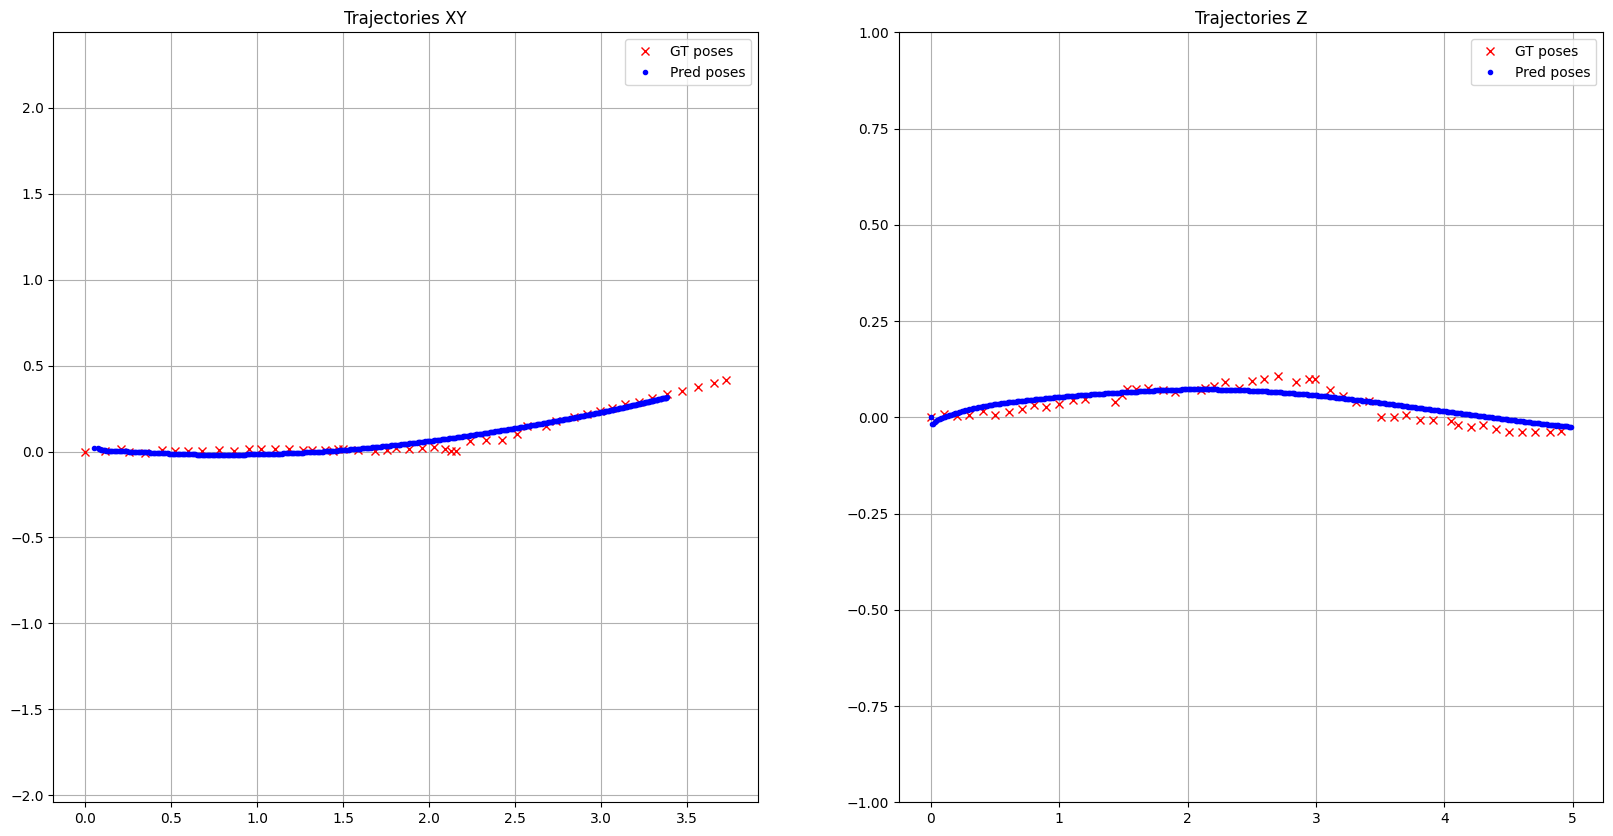

Iter 402/1000, Loss: 0.0035
Iter 403/1000, Loss: 0.0034
Iter 404/1000, Loss: 0.0033
Iter 405/1000, Loss: 0.0032
Iter 406/1000, Loss: 0.0032
Iter 407/1000, Loss: 0.0032
Iter 408/1000, Loss: 0.0032
Iter 409/1000, Loss: 0.0033
Iter 410/1000, Loss: 0.0034
Iter 411/1000, Loss: 0.0036
Iter 412/1000, Loss: 0.0042
Iter 413/1000, Loss: 0.0061
Iter 414/1000, Loss: 0.0103
Iter 415/1000, Loss: 0.0175
Iter 416/1000, Loss: 0.0196
Iter 417/1000, Loss: 0.0093
Iter 418/1000, Loss: 0.0033
Iter 419/1000, Loss: 0.0078
Iter 420/1000, Loss: 0.0113
Iter 421/1000, Loss: 0.0069
Iter 422/1000, Loss: 0.0034
Iter 423/1000, Loss: 0.0071
Iter 424/1000, Loss: 0.0086
Iter 425/1000, Loss: 0.0042
Iter 426/1000, Loss: 0.0041
Iter 427/1000, Loss: 0.0071
Iter 428/1000, Loss: 0.0054
Iter 429/1000, Loss: 0.0032
Iter 430/1000, Loss: 0.0049
Iter 431/1000, Loss: 0.0058
Iter 432/1000, Loss: 0.0039
Iter 433/1000, Loss: 0.0033
Iter 434/1000, Loss: 0.0046
Iter 435/1000, Loss: 0.0048
Iter 436/1000, Loss: 0.0034
Iter 437/1000, Loss:

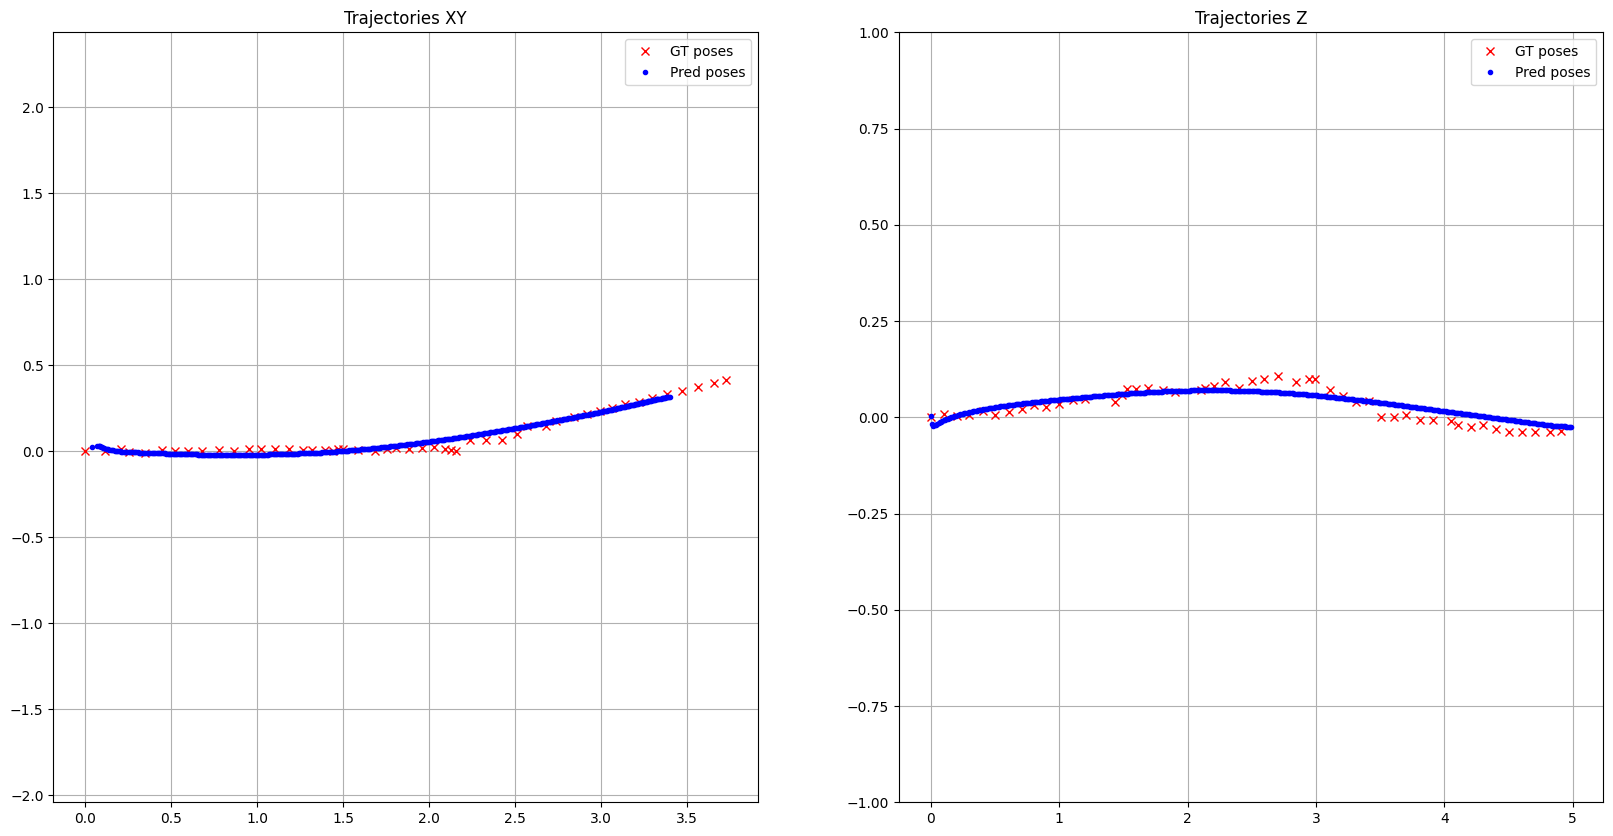

Iter 502/1000, Loss: 0.0034
Iter 503/1000, Loss: 0.0030
Iter 504/1000, Loss: 0.0027
Iter 505/1000, Loss: 0.0025
Iter 506/1000, Loss: 0.0025
Iter 507/1000, Loss: 0.0026
Iter 508/1000, Loss: 0.0028
Iter 509/1000, Loss: 0.0030
Iter 510/1000, Loss: 0.0031
Iter 511/1000, Loss: 0.0032
Iter 512/1000, Loss: 0.0033
Iter 513/1000, Loss: 0.0032
Iter 514/1000, Loss: 0.0031
Iter 515/1000, Loss: 0.0029
Iter 516/1000, Loss: 0.0028
Iter 517/1000, Loss: 0.0027
Iter 518/1000, Loss: 0.0026
Iter 519/1000, Loss: 0.0025
Iter 520/1000, Loss: 0.0025
Iter 521/1000, Loss: 0.0024
Iter 522/1000, Loss: 0.0024
Iter 523/1000, Loss: 0.0024
Iter 524/1000, Loss: 0.0024
Iter 525/1000, Loss: 0.0024
Iter 526/1000, Loss: 0.0024
Iter 527/1000, Loss: 0.0025
Iter 528/1000, Loss: 0.0025
Iter 529/1000, Loss: 0.0027
Iter 530/1000, Loss: 0.0029
Iter 531/1000, Loss: 0.0032
Iter 532/1000, Loss: 0.0039
Iter 533/1000, Loss: 0.0051
Iter 534/1000, Loss: 0.0068
Iter 535/1000, Loss: 0.0095
Iter 536/1000, Loss: 0.0107
Iter 537/1000, Loss:

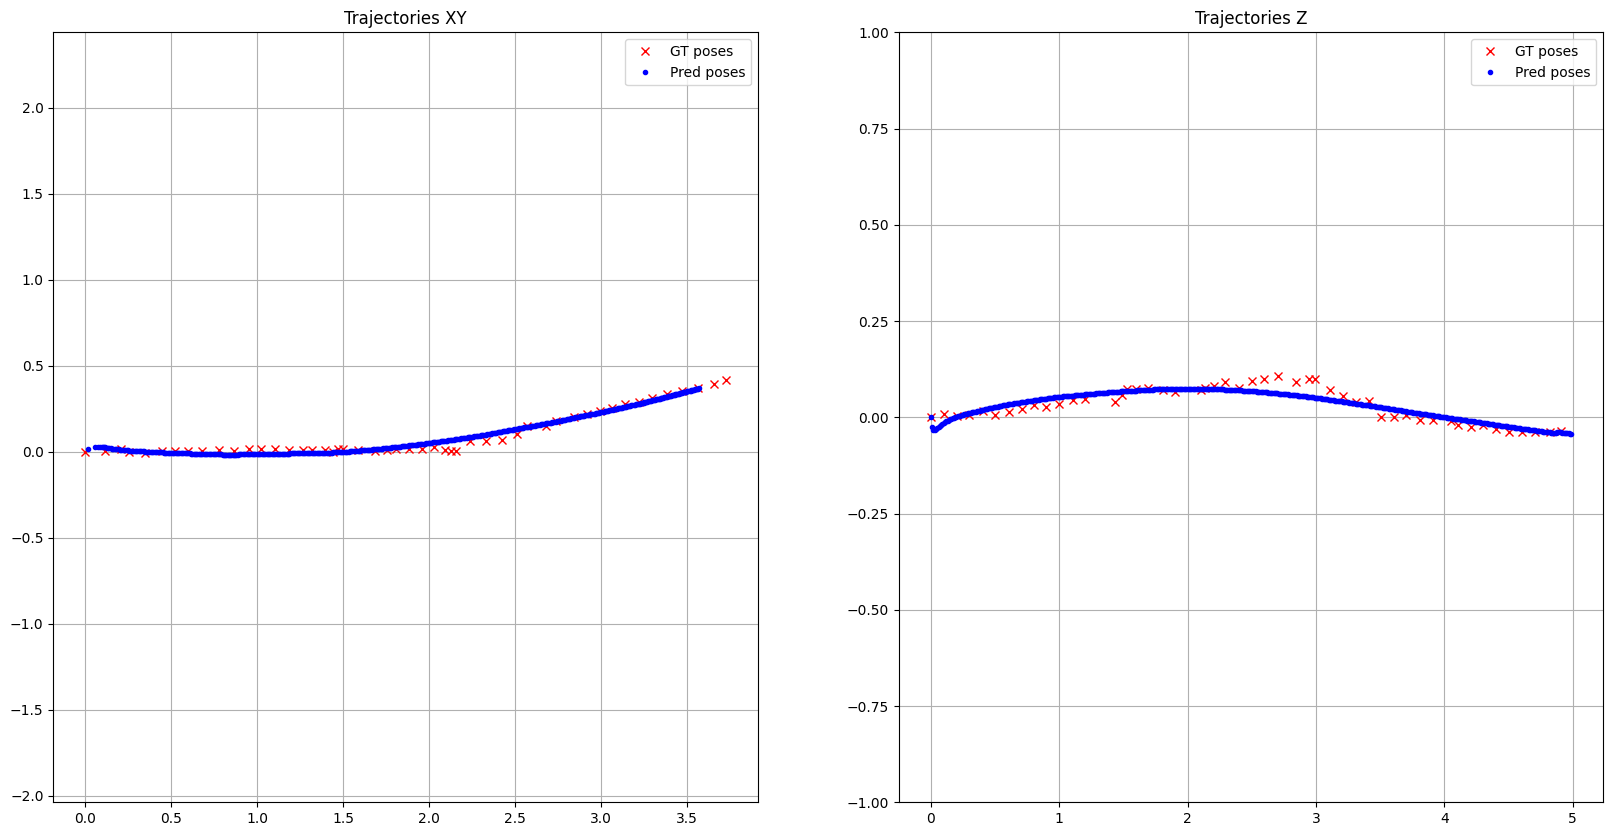

Iter 602/1000, Loss: 0.0022
Iter 603/1000, Loss: 0.0023
Iter 604/1000, Loss: 0.0024
Iter 605/1000, Loss: 0.0027
Iter 606/1000, Loss: 0.0033
Iter 607/1000, Loss: 0.0043
Iter 608/1000, Loss: 0.0065
Iter 609/1000, Loss: 0.0089
Iter 610/1000, Loss: 0.0124
Iter 611/1000, Loss: 0.0110
Iter 612/1000, Loss: 0.0084
Iter 613/1000, Loss: 0.0037
Iter 614/1000, Loss: 0.0023
Iter 615/1000, Loss: 0.0042
Iter 616/1000, Loss: 0.0062
Iter 617/1000, Loss: 0.0064
Iter 618/1000, Loss: 0.0038
Iter 619/1000, Loss: 0.0023
Iter 620/1000, Loss: 0.0030
Iter 621/1000, Loss: 0.0044
Iter 622/1000, Loss: 0.0048
Iter 623/1000, Loss: 0.0034
Iter 624/1000, Loss: 0.0023
Iter 625/1000, Loss: 0.0024
Iter 626/1000, Loss: 0.0032
Iter 627/1000, Loss: 0.0037
Iter 628/1000, Loss: 0.0031
Iter 629/1000, Loss: 0.0024
Iter 630/1000, Loss: 0.0021
Iter 631/1000, Loss: 0.0023
Iter 632/1000, Loss: 0.0027
Iter 633/1000, Loss: 0.0031
Iter 634/1000, Loss: 0.0032
Iter 635/1000, Loss: 0.0028
Iter 636/1000, Loss: 0.0023
Iter 637/1000, Loss:

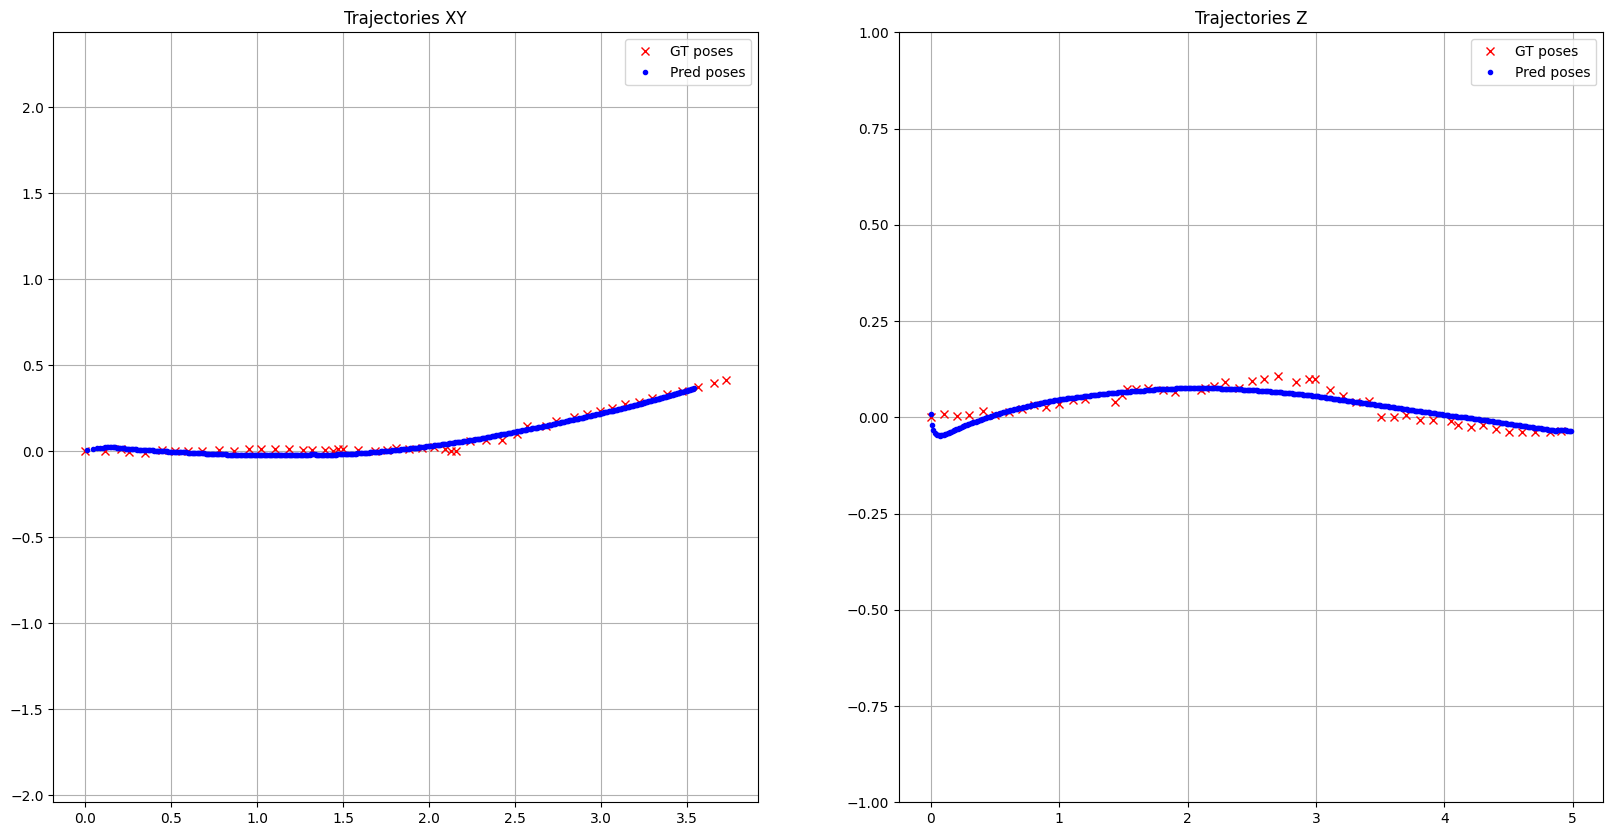

Iter 702/1000, Loss: 0.0033
Iter 703/1000, Loss: 0.0052
Iter 704/1000, Loss: 0.0043
Iter 705/1000, Loss: 0.0030
Iter 706/1000, Loss: 0.0023
Iter 707/1000, Loss: 0.0027
Iter 708/1000, Loss: 0.0031
Iter 709/1000, Loss: 0.0029
Iter 710/1000, Loss: 0.0024
Iter 711/1000, Loss: 0.0020
Iter 712/1000, Loss: 0.0024
Iter 713/1000, Loss: 0.0029
Iter 714/1000, Loss: 0.0027
Iter 715/1000, Loss: 0.0024
Iter 716/1000, Loss: 0.0021
Iter 717/1000, Loss: 0.0020
Iter 718/1000, Loss: 0.0022
Iter 719/1000, Loss: 0.0024
Iter 720/1000, Loss: 0.0024
Iter 721/1000, Loss: 0.0022
Iter 722/1000, Loss: 0.0020
Iter 723/1000, Loss: 0.0019
Iter 724/1000, Loss: 0.0020
Iter 725/1000, Loss: 0.0021
Iter 726/1000, Loss: 0.0022
Iter 727/1000, Loss: 0.0021
Iter 728/1000, Loss: 0.0020
Iter 729/1000, Loss: 0.0019
Iter 730/1000, Loss: 0.0019
Iter 731/1000, Loss: 0.0019
Iter 732/1000, Loss: 0.0020
Iter 733/1000, Loss: 0.0019
Iter 734/1000, Loss: 0.0019
Iter 735/1000, Loss: 0.0018
Iter 736/1000, Loss: 0.0018
Iter 737/1000, Loss:

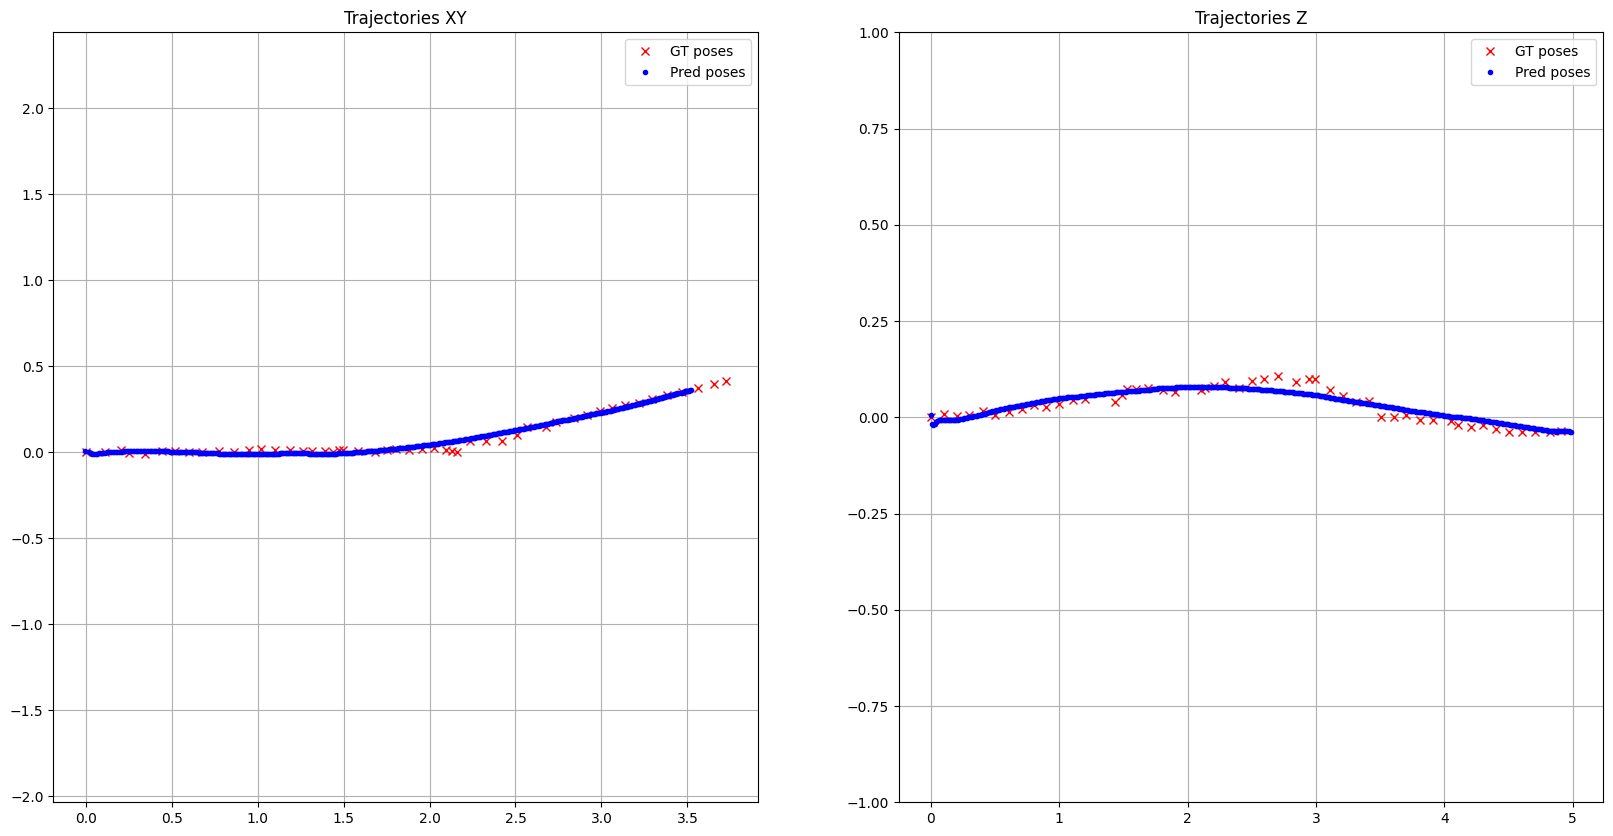

Iter 802/1000, Loss: 0.0025
Iter 803/1000, Loss: 0.0028
Iter 804/1000, Loss: 0.0028
Iter 805/1000, Loss: 0.0027
Iter 806/1000, Loss: 0.0024
Iter 807/1000, Loss: 0.0021
Iter 808/1000, Loss: 0.0019
Iter 809/1000, Loss: 0.0017
Iter 810/1000, Loss: 0.0017
Iter 811/1000, Loss: 0.0016
Iter 812/1000, Loss: 0.0017
Iter 813/1000, Loss: 0.0017
Iter 814/1000, Loss: 0.0018
Iter 815/1000, Loss: 0.0019
Iter 816/1000, Loss: 0.0020
Iter 817/1000, Loss: 0.0021
Iter 818/1000, Loss: 0.0023
Iter 819/1000, Loss: 0.0024
Iter 820/1000, Loss: 0.0026
Iter 821/1000, Loss: 0.0027
Iter 822/1000, Loss: 0.0028
Iter 823/1000, Loss: 0.0027
Iter 824/1000, Loss: 0.0027
Iter 825/1000, Loss: 0.0025
Iter 826/1000, Loss: 0.0024
Iter 827/1000, Loss: 0.0022
Iter 828/1000, Loss: 0.0020
Iter 829/1000, Loss: 0.0019
Iter 830/1000, Loss: 0.0017
Iter 831/1000, Loss: 0.0017
Iter 832/1000, Loss: 0.0016
Iter 833/1000, Loss: 0.0016
Iter 834/1000, Loss: 0.0016
Iter 835/1000, Loss: 0.0016
Iter 836/1000, Loss: 0.0017
Iter 837/1000, Loss:

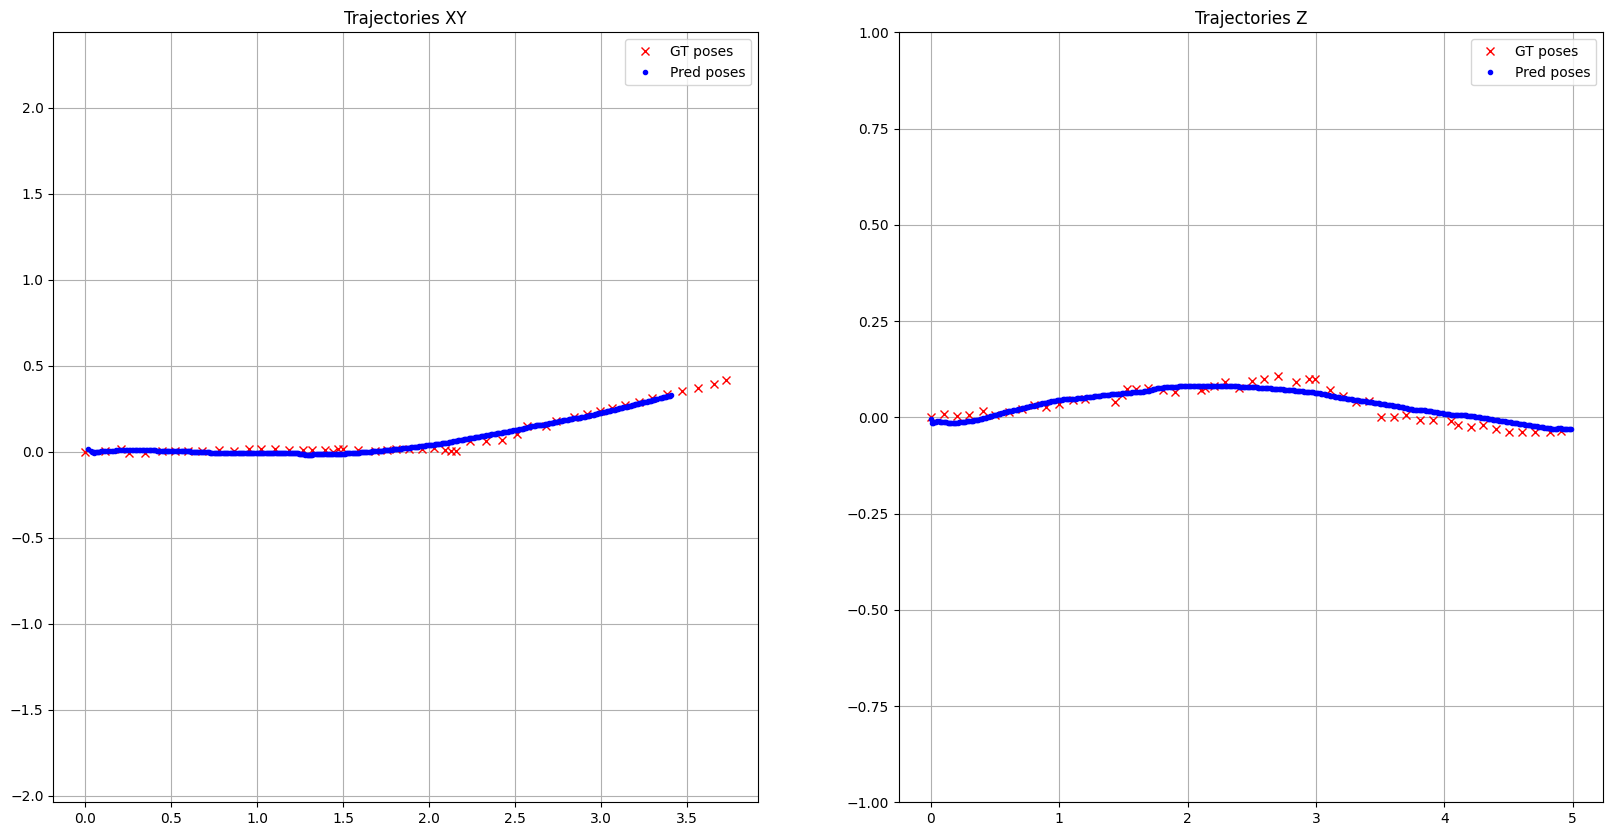

Iter 902/1000, Loss: 0.0061
Iter 903/1000, Loss: 0.0064
Iter 904/1000, Loss: 0.0039
Iter 905/1000, Loss: 0.0021
Iter 906/1000, Loss: 0.0016
Iter 907/1000, Loss: 0.0025
Iter 908/1000, Loss: 0.0038
Iter 909/1000, Loss: 0.0042
Iter 910/1000, Loss: 0.0039
Iter 911/1000, Loss: 0.0026
Iter 912/1000, Loss: 0.0017
Iter 913/1000, Loss: 0.0016
Iter 914/1000, Loss: 0.0021
Iter 915/1000, Loss: 0.0026
Iter 916/1000, Loss: 0.0026
Iter 917/1000, Loss: 0.0023
Iter 918/1000, Loss: 0.0017
Iter 919/1000, Loss: 0.0015
Iter 920/1000, Loss: 0.0016
Iter 921/1000, Loss: 0.0019
Iter 922/1000, Loss: 0.0021
Iter 923/1000, Loss: 0.0021
Iter 924/1000, Loss: 0.0019
Iter 925/1000, Loss: 0.0017
Iter 926/1000, Loss: 0.0015
Iter 927/1000, Loss: 0.0014
Iter 928/1000, Loss: 0.0015
Iter 929/1000, Loss: 0.0016
Iter 930/1000, Loss: 0.0017
Iter 931/1000, Loss: 0.0018
Iter 932/1000, Loss: 0.0017
Iter 933/1000, Loss: 0.0016
Iter 934/1000, Loss: 0.0015
Iter 935/1000, Loss: 0.0014
Iter 936/1000, Loss: 0.0014
Iter 937/1000, Loss:

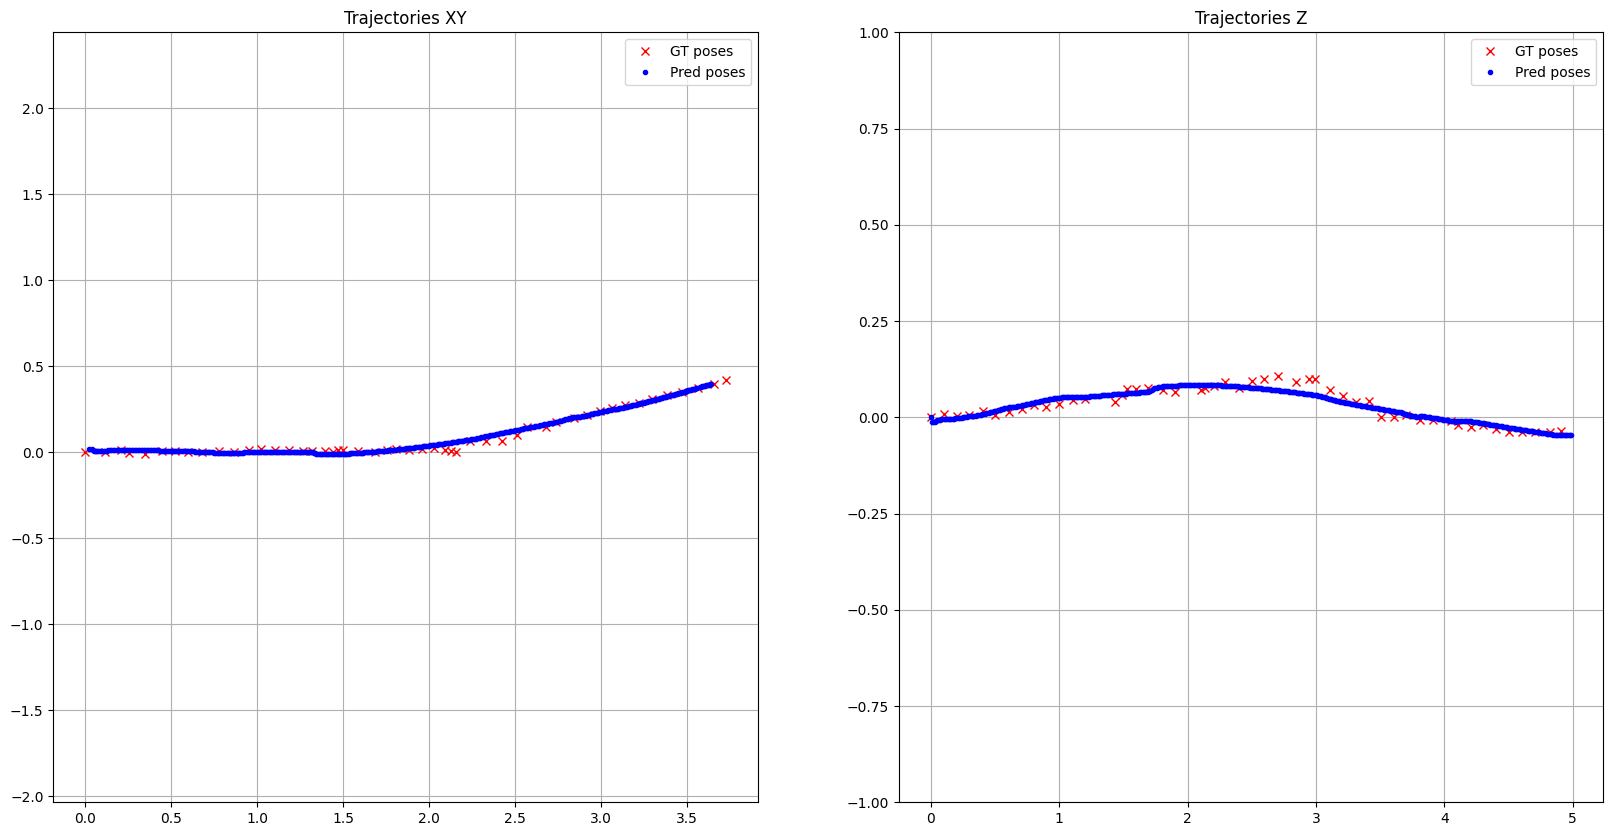

In [9]:
import matplotlib.pyplot as plt

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move tensors and model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch = [b.to(device) for b in batch]
hm, control_ts, controls, traj_ts, xyz_rpy = batch
xyz_rpy0 = xyz_rpy[:, 0]

# Training loop
num_iters = 1000
for i in range(num_iters):
    optimizer.zero_grad()
    
    xyz_rpy_pred = model(xyz_rpy0, controls, hm)
    
    # find the closest timesteps in the trajectory to the ground truth timesteps
    ts_ids = torch.argmin(torch.abs(control_ts.unsqueeze(1) - traj_ts.unsqueeze(2)), dim=2)
    # compute the loss as the mean squared error between the predicted and ground truth poses
    loss = criterion(xyz_rpy_pred[torch.arange(batch_size).unsqueeze(1), ts_ids], xyz_rpy)
    
    loss.backward()
    optimizer.step()
    
    print(f"Iter {i+1}/{num_iters}, Loss: {loss.item():.4f}")
    
    # visualization
    if i % 100 == 0 or i == num_iters - 1:
        with torch.no_grad():
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 2, 1)
            plt.plot(xyz_rpy[0, :, 0].cpu().numpy(), xyz_rpy[0, :, 1].cpu().numpy(), 'xr', label='GT poses')
            plt.plot(xyz_rpy_pred[0, :, 0].cpu().numpy(), xyz_rpy_pred[0, :, 1].cpu().numpy(), '.b', label='Pred poses')
            plt.grid()
            plt.axis('equal')
            plt.legend()
            plt.title('Trajectories XY')
            # # plot lines between corresponding points from the ground truth and predicted trajectories (use ts_ids)
            # for j in range(xyz_rpy.shape[1]):
            #     plt.plot([xyz_rpy[0, j, 0].cpu().numpy(), xyz_rpy_pred[0, ts_ids[0, j], 0].cpu().numpy()],
            #              [xyz_rpy[0, j, 1].cpu().numpy(), xyz_rpy_pred[0, ts_ids[0, j], 1].cpu().numpy()], 'g')
            
            plt.subplot(1, 2, 2)
            plt.plot(traj_ts[0].cpu().numpy(), xyz_rpy[0, :, 2].cpu().numpy(), 'xr', label='GT poses')
            plt.plot(control_ts[0].cpu().numpy(), xyz_rpy_pred[0, :, 2].cpu().numpy(), '.b', label='Pred poses')
            plt.grid()
            plt.ylim(-1, 1)
            plt.legend()
            plt.title('Trajectories Z')
    
            plt.show()